## TO DO - Aug 26th
* add number of timepoints for each patients on graph
* do EDA for: 
    * UPDRS with average. NB: NUPDRS3 contains a column with Hoehn & Yahr Stage
    * add correlation matrix
    * Non-motor assessments, Gen Medicak Info, Neuro assessements. 
* to plot as well: unbalance of class in the dataset using an histogram
> modify the histogram because does not plot the good thing as is right now...

## REFERENCES

* **Data viz - Jesus**: 
 * http://localhost:8888/notebooks/00_TRAINING/02_DSR/VIZ_course/PLOTLY/code_for_slides.ipynb
 * http://localhost:8888/notebooks/00_TRAINING/02_DSR/VIZ_course/PLOTLY/code_to_learn.ipynb
 * http://localhost:8888/notebooks/01_Dev/02_Python-tutorials_Jupyter-notebooks/03_Python_forDS_Udemy/Plotly%20and%20cufflinks_AM.ipynb

### Specific to time-series: 
* https://github.com/ChadFulton/tsa-notebooks
* https://github.com/maxim5/time-series-machine-learning

### Kaggle Kernels
* https://www.kaggle.com/c/web-traffic-time-series-forecasting

## 0. Imports & functions

In [1]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.plotly as py
import cufflinks as cf
import seaborn as sns
import urllib.parse
from glob import glob
import os
import ntpath 
import zipfile
from datetime import datetime

#and enable the offline mode in the notebook (not needed in Jupyter Lab)
#py.offline.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')
PPMI_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/'

In [2]:
#!pip install cufflinks --upgrade

In [3]:
def reading_csv_files(folder_path):
    # saving all the csv files in a dataframe
    import os
    import glob
    # glob.glob('*.csv') #find all the csv files in a pathname. 
    os.chdir(folder_path)
    csv_files = [i for i in glob.glob('*.csv')]

    # Reading each csv file and storing them in a dictionnary containing the file name and the dataframe
    dict_files={}
    files_names=[]
    for files in csv_files:
        df=pd.read_csv(files,engine='python')
        basepath, filename=ntpath.split(files)
        files_names.append(filename)
        dict_files[filename]=df
        
    # Calculating the # of rows and features for each dataframe and storing them in a list of tuples
    shape_df=[]
    for i in range(0,len(dict_files.keys())):
        nrows, ncols=(len(dict_files[files_names[i]]),len(dict_files[files_names[i]].columns))
        shape_df.append((nrows,ncols))

    return (shape_df,files_names,dict_files)

In [4]:
def number_of_patients(df):
    '''return the number of patients in each csv files and the number of events'''
    patients=len(list(set(df['PATNO'])))
    if 'EVENT_ID' in df.columns:
        events=len(list(set(df['EVENT_ID'])))
    else:
        events='no TS data'
    return (patients,events)

In [5]:
def features_selection(df, SEL):
    '''cleanier way to do features selection in each csv file'''
    return df_sel

In [6]:
def patients_selection(df, threshold=6):
    '''return a dataframe containing only the patients with number of visits > threshold'''
    if 'PATNO' in df.columns: 
        visits_number_by_pat=df.groupby('PATNO').size().sort_values(ascending=False)
        mask_sel=visits_number_by_pat>=threshold
        patients_sel=list(mask_sel[mask_sel.values==True].index)
        df=df.loc[df['PATNO'].isin(patients_sel),:]
        df=df.sort_values('PATNO')
        return (patients_sel, df)
    else:
        print("There is no 'PATNO' column in the dataframe")

In [7]:
def PD_patients_selection(df):
    folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/1-Subject-Characteristics/'
    files_names=reading_csv_files(folder_path)[1]
    dict_files=reading_csv_files(folder_path)[2]

    ### Patient_Status - actually useful for selecting only the PD patients in each table
    PRODROMA=dict_files[files_names[0]]
    PD_cat=['PD','REGPD','GENPD']
    PD_patients=list(PRODROMA.loc[PRODROMA['RECRUITMENT_CAT'].isin(PD_cat),'PATNO'])
    sub_df=df.loc[df['PATNO'].isin(PD_patients),:]
    return sub_df

In [8]:
def patients_sampling(df,sample_size=25,seed=123):
    np.random.seed(seed)
    sample=list(np.random.randint(0,number_of_patients(diagfeat_EADL)[0],sample_size+1))
    patients_sample=pd.Series(list(set(df['PATNO'])))[sample]
    patients_sample=list(patients_sample.values)
    sub_df=df.loc[df['PATNO'].isin(patients_sample),:]
    return sub_df

In [9]:
def INFODT_date(df):
    if 'INFODT' in df.columns: 
        df['INFODT_date']=df['INFODT'].apply(lambda x: datetime.strptime(x,'%m/%Y'))
    return df

In [10]:
def plot_distr_visits_pat(df,fig_name):
    ''''''
    # distribution of patients over the number of visits
    visits_pat=df.groupby('PATNO').size()
    plt.hist(x=visits_pat,bins=list(set(visits_pat.values)),normed=True,rwidth=0.5)
    plt_path_name='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/assets/figs-EDA/distr_visits_pat'
    plt_path_name=plt_path_name+fig_name
    plt.savefig(plt_path_name)

In [125]:
def plotting_feat(df,fig_name,y="sum_feat"):
    # first plot 
    sns.set(style="darkgrid")
    g = sns.FacetGrid(df, col="PATNO", margin_titles=True,col_wrap=5)
    g.map(plt.hist, y, color="steelblue")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('distribution of feature per number of visits')
    plt_path_name='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/assets/figs-EDA/hist_visits_feat'
    plt_path_name=plt_path_name+fig_name
    g.savefig(plt_path_name)
    plt.close()
    
    # second plot
    g = sns.FacetGrid(df, col="PATNO", margin_titles=True,col_wrap=5)
    g.map(plt.plot, y, color="steelblue")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('evolution of feature overtime by patient')
    plt_path_name='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/assets/figs-EDA/lineplt_DT_feat'
    plt_path_name=plt_path_name+fig_name
    g.savefig(plt_path_name)
    plt.close()
    
    # Third plot
    ax=sns.boxplot(y=y,x="PATNO", data=df)
    ax.figure.set_size_inches(w=20,h=10)
    plt_path_name='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/assets/figs-EDA/boxplot_PATNO_feat'
    ax.fig.suptitle('distribution of feature per patient')
    plt_path_name=plt_path_name+fig_name
    ax.figure.savefig(fname=plt_path_name)
    plt.close()

In [123]:
def dataset_balance_analysis(df,feat):
    ser=df.groupby(by=['EVENT_ID',feat]).size()
    visits=list(ser.index.get_level_values(0))
    feat=list(ser.index.get_level_values(1))
    ax=sns.barplot(x=feat,y=list(ser.values),hue=visits)
    ax.figure.set_size_inches(w=20,h=10)
    ax.figure.suptitle('dataset class balance analysis by visit')

In [131]:
def dataset_balance_analysis_allEvents(df,feat,width=3):
        ser=df.groupby(by=feat).size()
        plt.bar(x=list(ser.index),height=list(ser.values),width=width)

## 1. Data-processing

###  Getting the PD people - 1052 patients using RECRUITMENT_CAT

In [14]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/1-Subject-Characteristics/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### Patient_Status - actually useful for selecting only the PD patients in each table
PRODROMA=dict_files[files_names[0]]
PD_cat=['PD','REGPD','GENPD']
PD_patients=list(PRODROMA.loc[PRODROMA['RECRUITMENT_CAT'].isin(PD_cat),'PATNO'])
print('number of PD patients:{}'.format(len(PD_patients)))

number of PD patients:1052


### Creating the dataset with selected features - DIAGFEAT. 

In [39]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/5-Medical-History/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'Diagnostic_Features.csv': useful: Feat-PD - 1670 patients.
DIAGFEAT=dict_files[files_names[1]]

#using SEL2 for now: removing features with Non applicable values
SEL2=[ 'REC_ID','PATNO', 'EVENT_ID','INFODT',
       'DFSTROKE', 'DFRSKFCT', 'DFPRESNT', 'DFRPROG', 'DFSTATIC', 'DFHEMPRK',
       'DFAGESX', 'DFOTHCRS', 'DFCRSCM', 'DFRTREMP', 'DFRTREMA', 'DFPATREM',
       'DFOTHTRM', 'DFTREMCM', 'DFRIGIDP', 'DFRIGIDA', 'DFAXRIG', 'DFUNIRIG',
       'DFTONE', 'DFOTHRIG', 'DFRIGCM', 'DFBRADYP', 'DFBRADYA', 'DFAKINES',
       'DFBRPLUS', 'DFOTHABR', 'DFABRCM', 'DFPGDIST', 'DFGAIT', 'DFFREEZ',
       'DFFALLS', 'DFOTHPG', 'DFPGCM', 'DFPSYCH', 'DFCOGNIT', 'DFDYSTON',
       'DFCHOREA', 'DFMYOCLO', 'DFOTHHYP', 'DFHYPCM', 'DFHEMTRO', 'DFPSHYPO',
       'DFSEXDYS', 'DFURDYS', 'DFBWLDYS', 'DFOCULO', 'DFEYELID', 'DFNEURAB',
       'DFRAPSPE', 'DFBULBAR','DFATYP']
## features removed.
#SEL2=SEL.remove('DFCTSCAN')
#SEL2=SEL.remove('DFDOPRSP')
#SEL2=SEL.remove('DFMRI')
DIAGFEAT_sel=DIAGFEAT[SEL2]

# seleting the PD_patients with nulbe of visits > Threshold
DIAGFEAT_sel=PD_patients_selection(DIAGFEAT_sel)
DIAGFEAT_sel=patients_selection(DIAGFEAT_sel,6)[1]
DIAGFEAT_sel.reset_index(drop=True,inplace=True)

#Add one feature: summing the binary PD measurements 
DIAGFEAT_sel['sum_feat']=DIAGFEAT_sel.iloc[:,range(4,55)].sum(axis=1)
print(len(DIAGFEAT_sel),len(list(set(DIAGFEAT_sel['PATNO']))))

1300 195


### Creating the Labels - MODSEADL & Merging w/ DIAGFEAT. 

In [45]:
### 'Modified_Schwab_+_England_ADL.csv' - 1837 patients
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/6-Motor-Assessments/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

MODSEADL=dict_files[files_names[6]]

# seleting the patients and features
SEL=['REC_ID','PATNO','EVENT_ID','INFODT','MSEADLG']
MODSEADL_sel=MODSEADL[SEL]
MODSEADL_sel=PD_patients_selection(MODSEADL_sel)
MODSEADL_sel=patients_selection(MODSEADL_sel,6)[1]

# finding the patient set intersection between features and labels 
labels_pat=patients_selection(MODSEADL_sel,6)[0] 
feat_pat=patients_selection(DIAGFEAT_sel,6)[0]
intersect=list(set(labels_pat) & set(feat_pat)) # ok cool: all the patients in DIAGFEAT are in MODSEADL. 
print(len(intersect))
# selecting only the intersect patients.
MODSEADL_sel2=MODSEADL_sel.loc[MODSEADL_sel['PATNO'].isin(intersect),:]

# merging features & label for plotting: 
diagfeat_EADL=pd.merge(DIAGFEAT_sel,MODSEADL_sel2,on=['PATNO','EVENT_ID','INFODT'],how='inner')
diagfeat_EADL=INFODT_date(diagfeat_EADL)
print(len(diagfeat_EADL),len(list(set(diagfeat_EADL['PATNO']))))
diagfeat_EADL.head(3)
diagfeat_EADL.columns

195
1290 195


Index(['REC_ID_x', 'PATNO', 'EVENT_ID', 'INFODT', 'DFSTROKE', 'DFRSKFCT',
       'DFPRESNT', 'DFRPROG', 'DFSTATIC', 'DFHEMPRK', 'DFAGESX', 'DFOTHCRS',
       'DFCRSCM', 'DFRTREMP', 'DFRTREMA', 'DFPATREM', 'DFOTHTRM', 'DFTREMCM',
       'DFRIGIDP', 'DFRIGIDA', 'DFAXRIG', 'DFUNIRIG', 'DFTONE', 'DFOTHRIG',
       'DFRIGCM', 'DFBRADYP', 'DFBRADYA', 'DFAKINES', 'DFBRPLUS', 'DFOTHABR',
       'DFABRCM', 'DFPGDIST', 'DFGAIT', 'DFFREEZ', 'DFFALLS', 'DFOTHPG',
       'DFPGCM', 'DFPSYCH', 'DFCOGNIT', 'DFDYSTON', 'DFCHOREA', 'DFMYOCLO',
       'DFOTHHYP', 'DFHYPCM', 'DFHEMTRO', 'DFPSHYPO', 'DFSEXDYS', 'DFURDYS',
       'DFBWLDYS', 'DFOCULO', 'DFEYELID', 'DFNEURAB', 'DFRAPSPE', 'DFBULBAR',
       'DFATYP', 'sum_feat', 'REC_ID_y', 'MSEADLG', 'INFODT_date'],
      dtype='object')

### Heatmap of all the features

53


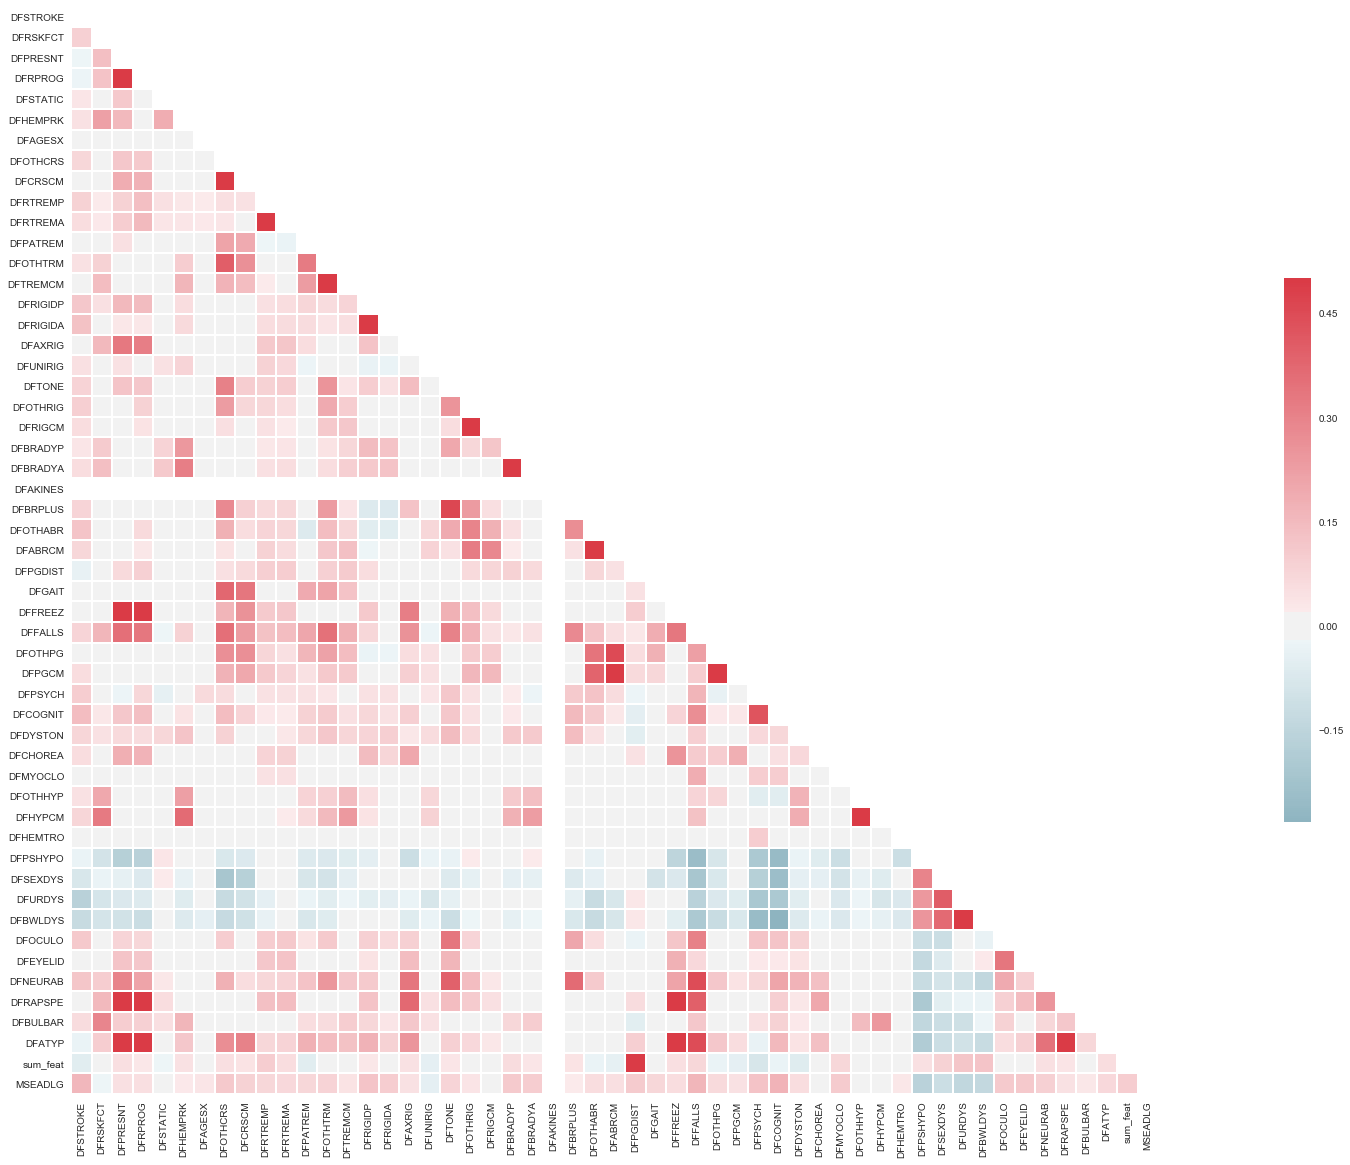

In [135]:
from string import ascii_letters

sns.set(style="white")

sel=['DFSTROKE', 'DFRSKFCT',
       'DFPRESNT', 'DFRPROG', 'DFSTATIC', 'DFHEMPRK', 'DFAGESX', 'DFOTHCRS',
       'DFCRSCM', 'DFRTREMP', 'DFRTREMA', 'DFPATREM', 'DFOTHTRM', 'DFTREMCM',
       'DFRIGIDP', 'DFRIGIDA', 'DFAXRIG', 'DFUNIRIG', 'DFTONE', 'DFOTHRIG',
       'DFRIGCM', 'DFBRADYP', 'DFBRADYA', 'DFAKINES', 'DFBRPLUS', 'DFOTHABR',
       'DFABRCM', 'DFPGDIST', 'DFGAIT', 'DFFREEZ', 'DFFALLS', 'DFOTHPG',
       'DFPGCM', 'DFPSYCH', 'DFCOGNIT', 'DFDYSTON', 'DFCHOREA', 'DFMYOCLO',
       'DFOTHHYP', 'DFHYPCM', 'DFHEMTRO', 'DFPSHYPO', 'DFSEXDYS', 'DFURDYS',
       'DFBWLDYS', 'DFOCULO', 'DFEYELID', 'DFNEURAB', 'DFRAPSPE', 'DFBULBAR',
       'DFATYP', 'sum_feat', 'MSEADLG']
print(len(sel))
d = diagfeat_EADL[sel]

# Compute the correlation matrix
corr = d.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(45, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5})

NB: **As there are correlation between features > add a CNN?**
* Moreover, the neural-network architecture that I have designed is a toy model. It can be easily improved by adding CNN and dropout layers. The CNN is useful here since there are correlations in data (CNN layer is a good way to probe the local structure of data).

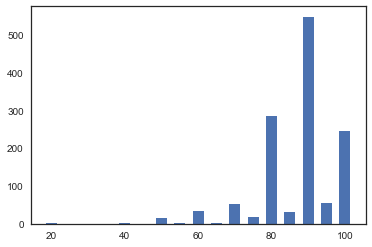

In [63]:
dataset_balance_analysis_allEvents(diagfeat_EADL,'MSEADLG')

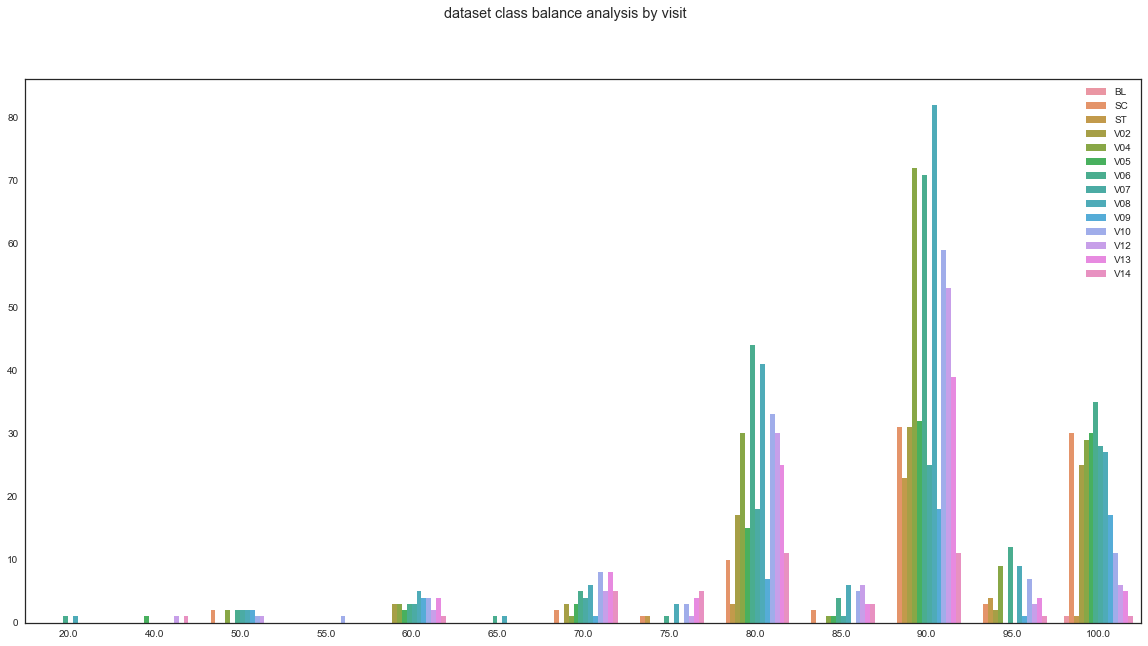

In [124]:
dataset_balance_analysis(df=diagfeat_EADL,feat='MSEADLG')

## other labels - UPDRS scale. 

In [20]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/6-Motor-Assessments/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'MDS_UPDRS_Part_I.csv' - 2010 patients
NUPDRS1=dict_files[files_names[2]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'NP1COG', 'NP1HALL', 'NP1DPRS', 'NP1ANXS', 'NP1APAT',
       'NP1DDS']
NUPDRS1_sel=NUPDRS1[SEL]
NUPDRS1_sel=INFODT_date(NUPDRS1_sel)
NUPDRS1_sel['sum_feat']=NUPDRS1_sel[['NP1COG', 'NP1HALL', 'NP1DPRS', 'NP1ANXS', 'NP1APAT',
       'NP1DDS']].sum(axis=1)
NUPDRS1_sel=PD_patients_selection(NUPDRS1_sel)
NUPDRS1_sel=patients_selection(NUPDRS1_sel)[1]
#print('UPDRS1:{}'.format((len(NUPDRS1_sel),len(list(set(NUPDRS1_sel['PATNO']))))))
print(len(NUPDRS1_sel)),print(len(list(set(NUPDRS1_sel['PATNO']))))

### 'MDS_UPDRS_Part_II__Patient_Questionnaire.csv' - 2011 patients
NUPDRS2P=dict_files[files_names[11]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'NP2SPCH', 'NP2SALV', 'NP2SWAL', 'NP2EAT', 'NP2DRES',
       'NP2HYGN', 'NP2HWRT', 'NP2HOBB', 'NP2TURN', 'NP2TRMR', 'NP2RISE',
       'NP2WALK', 'NP2FREZ']
NUPDRS2P_sel=NUPDRS2P[SEL]
NUPDRS2P_sel=INFODT_date(NUPDRS2P_sel)
NUPDRS2P_sel=PD_patients_selection(NUPDRS2P_sel)
NUPDRS2P_sel['sum_feat']=NUPDRS2P_sel[['NP2SPCH', 'NP2SALV', 'NP2SWAL', 'NP2EAT', 'NP2DRES',
       'NP2HYGN', 'NP2HWRT', 'NP2HOBB', 'NP2TURN', 'NP2TRMR', 'NP2RISE',
       'NP2WALK', 'NP2FREZ']].sum(axis=1)
NUPDRS2P_sel=patients_selection(NUPDRS2P_sel)[1]
#print('UPDRS2P:({},{})'.format((len(NUPDRS2P_sel),len(list(set(NUPDRS2P_sel['PATNO'])))))))
print(len(NUPDRS2P_sel)),print(len(list(set(NUPDRS2P_sel['PATNO']))))

### 'MDS_UPDRS_Part_III.csv' - 2010 patients
NUPDRS3=dict_files[files_names[7]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'CMEDTM', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU',
       'NP3RIGLU', 'PN3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR',
       'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR',
       'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR',
       'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU',
       'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'DYSKPRES',
       'DYSKIRAT', 'NHY', 'ANNUAL_TIME_BTW_DOSE_NUPDRS', 'ON_OFF_DOSE',
       'PD_MED_USE']
NUPDRS3_sel=NUPDRS3[SEL]
NUPDRS3_sel=INFODT_date(NUPDRS3_sel)
NUPDRS3_sel=PD_patients_selection(NUPDRS3_sel)
NUPDRS3_sel['sum_feat']=NUPDRS3_sel[['NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU',
       'NP3RIGLU', 'PN3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR',
       'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR',
       'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR',
       'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU',
       'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON']].sum(axis=1)
NUPDRS3_sel=patients_selection(NUPDRS3_sel)[1]
#print('UPDRS3:{}'.format((len(NUPDRS3_sel),len(list(set(NUPDRS3_sel['PATNO']))))))
print(len(NUPDRS3_sel)),print(len(list(set(NUPDRS3_sel['PATNO']))))


### 'MDS_UPDRS_Part_IV.csv' - 860 patients
NUPDRS4=dict_files[files_names[5]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'NP4WDYSK', 'NP4DYSKI', 'NP4OFF', 'NP4FLCTI', 'NP4FLCTX', 'NP4DYSTN']
NUPDRS4_sel=NUPDRS4[SEL]
NUPDRS4_sel=INFODT_date(NUPDRS4_sel)
NUPDRS4_sel=PD_patients_selection(NUPDRS4_sel)
NUPDRS4_sel['sum_feat']=NUPDRS4_sel[['NP4WDYSK', 'NP4DYSKI', 'NP4OFF', 
                                     'NP4FLCTI', 'NP4FLCTX', 'NP4DYSTN']].sum(axis=1)
NUPDRS4_sel=patients_selection(NUPDRS4_sel)[1]
#print('UPDRS4:{}'.format((len(NUPDRS4_sel),len(list(set(NUPDRS4_sel['PATNO']))))))
print(len(NUPDRS4_sel)),print(len(list(set(NUPDRS4_sel['PATNO']))))

#merging NUPDRS1 & 2P
NUPDRS1_2P=pd.merge(NUPDRS1_sel,NUPDRS2P_sel,how='inner',on=['PATNO','EVENT_ID','INFODT'])

6661
567
6661
567
8218
604
3438
401


In [21]:
#merge DIAGFEAT w/ UPDRS
diagfeat_NUPDRS1_2P=pd.merge(DIAGFEAT_sel,NUPDRS1_2P,how='inner',on=['PATNO','EVENT_ID','INFODT'])
print(len(diagfeat_NUPDRS1_2P),len(list(set(diagfeat_NUPDRS1_2P['PATNO']))))

diagfeat_NUPDRS3=pd.merge(DIAGFEAT_sel,NUPDRS3_sel,how='inner',on=['PATNO','EVENT_ID','INFODT'])
print(len(diagfeat_NUPDRS3),len(list(set(diagfeat_NUPDRS3['PATNO']))))

1285 195
1817 195


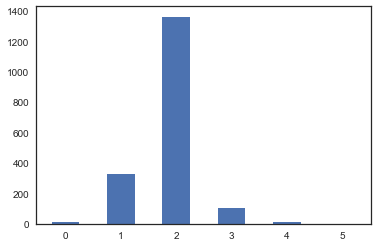

In [133]:
dataset_balance_analysis_allEvents(diagfeat_NUPDRS3,'NHY',width=0.5)

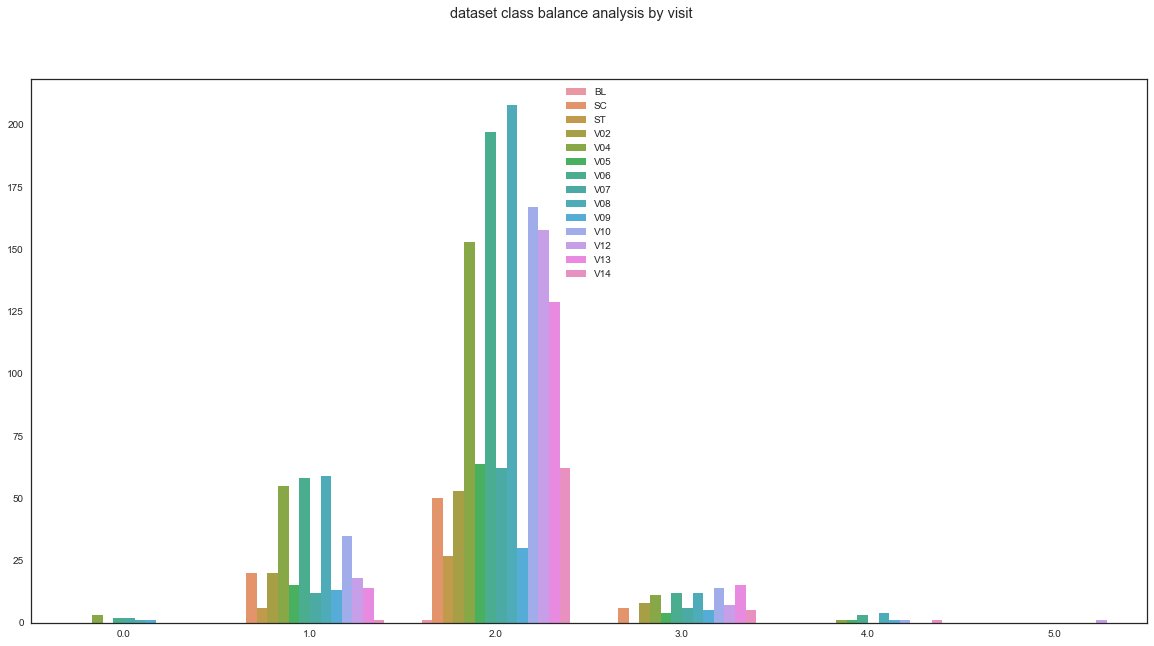

In [134]:
dataset_balance_analysis(diagfeat_NUPDRS3,'NHY')

## 2-Plotting. 

### 1. DIAGFEAT/MODSEADL

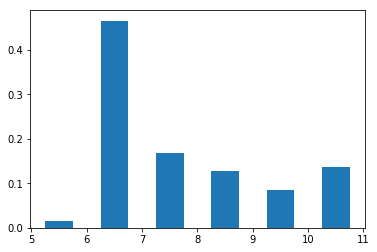

In [26]:
# distribution of patients over the number of visits
plot_distr_visits_pat(diagfeat_EADL,fig_name='diagfeat_EADL.png')

### DIAGFEAT

In [27]:
import cufflinks as cf
# Configure it to work offline:
cf.go_offline(connected=True)

df_3051=diagfeat_EADL.loc[diagfeat_EADL['PATNO']==3051,:]
df_3051.set_index('INFODT',inplace=True)
df_3051['var_sumfeat']=df_3051.iloc[:,range(3,54)].sum(axis=1)
df_3051_sumfeat=df_3051.loc[:,'var_sumfeat']
df_3051_plot=df_3051.iloc[:,range(3,54)]

#df_3051_plot.iplot(kind='scatter',filename='PATNO 3051 Diag Feat over time',mode='lines+markers')
#find something better than scatter plot.

In [28]:
# Plotting the labels of multiple patients
sub_df=patients_sampling(diagfeat_EADL)
plotting_feat(sub_df,fig_name='_DIAGFEAT')

### MODSEADL

In [29]:
plotting_feat(sub_df,fig_name='_MODSEADL.png',y="MSEADLG")

### UPDRS

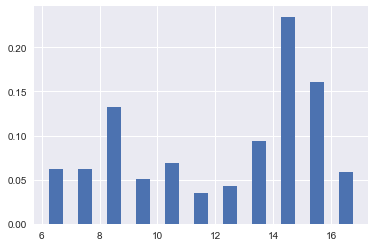

In [30]:
plot_distr_visits_pat(NUPDRS1_sel,fig_name='_UPDRS1.png')
sub_df_UPDRS1=patients_sampling(NUPDRS1_sel)

In [31]:
plotting_feat(sub_df_UPDRS1,fig_name='_UPDRS1.png')

In [32]:
plot_distr_visits_pat(NUPDRS2P_sel,'_UPDRS2P.png')
sub_df_UPDRS2P=patients_sampling(NUPDRS2P_sel)
plotting_feat(sub_df_UPDRS2P,fig_name='_UPDRS12P.png')

In [33]:
plot_distr_visits_pat(NUPDRS3_sel,fig_name='_UPDRS3.png')
sub_df_UPDRS3=patients_sampling(NUPDRS3_sel)
plotting_feat(sub_df_UPDRS3,fig_name='_UPDRS3.png')

In [34]:
plot_distr_visits_pat(NUPDRS4_sel,fig_name='_UPDRS4.png')
sub_df_UPDRS4=patients_sampling(NUPDRS4_sel)
plotting_feat(sub_df_UPDRS4,fig_name='_UPDRS4.png')

### Yoehn and Hahn Scale

In [35]:
sub_df_UPDRS3=patients_sampling(NUPDRS3_sel)
plotting_feat(sub_df_UPDRS3,fig_name='_Yoehn-Hahn.png',y="NHY")

In [36]:
#ax = sns.stripplot(x="PATNO", y="MSEADLG",data=sub_df, jitter=True)
#ax.figure.set_size_inches(w=20,h=10)
#plt.show()